## 2022 CVE CWE Review 

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2002..2022}.json.zip 
!unzip -o "*.zip" 
!wget https://raw.githubusercontent.com/CVEProject/cve-website/dev/src/assets/data/CNAsList.json

In [2]:

from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import calplot
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [3]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                assigner = entry['cve']['CVE_data_meta']['ASSIGNER']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
thisyear = ((nvd['Published'] > '2022-01-01') & (nvd['Published']  < '2022-12-31'))
nvd = nvd.loc[thisyear]
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
startdate = date(2022, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

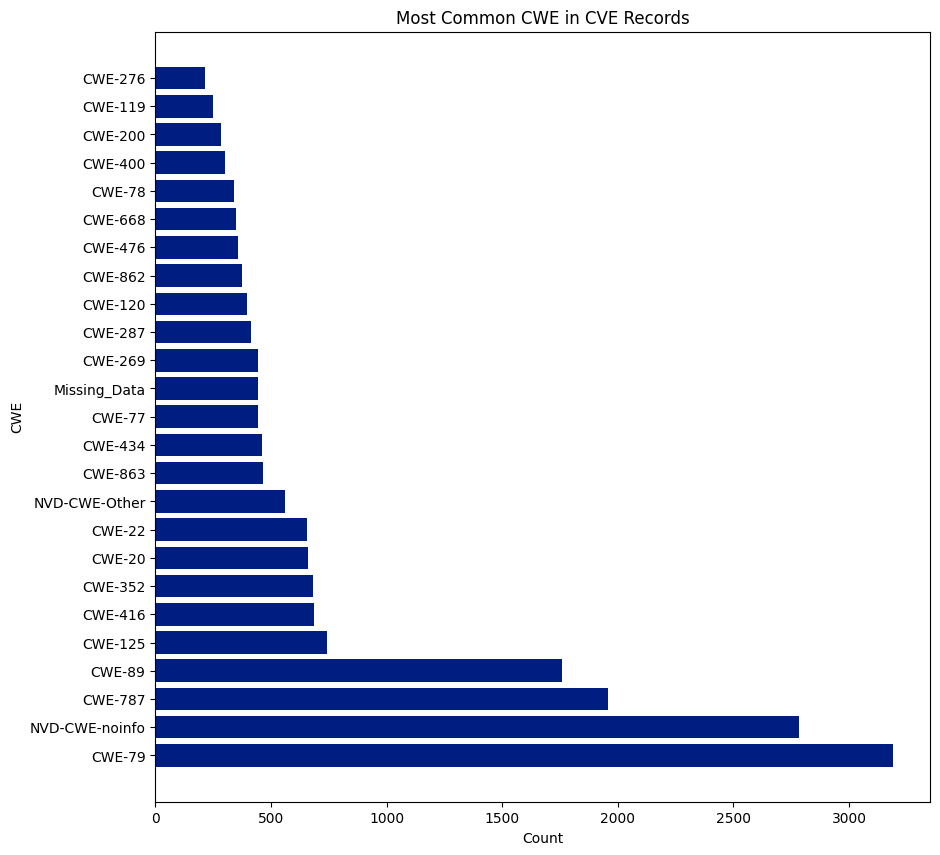

In [6]:
nvd_cwe = nvd['CWE'].value_counts()
nvd_cwe = nvd_cwe.reset_index()
nvd_cwe.columns = ['CWE', 'Counts']
nvd_cwe_graph = nvd_cwe[nvd_cwe.Counts > 100].head(25)
plt.figure(figsize=(10,10));
plt.barh("CWE", "Counts", data = nvd_cwe_graph, color="#001d82");
plt.xlabel("Count"); 
plt.ylabel("CWE") ;
plt.title("Most Common CWE in CVE Records");

In [7]:
nvd_cwe.head(10)

,CWE,Counts
0,CWE-79,3192
1,NVD-CWE-noinfo,2782
2,CWE-787,1960
3,CWE-89,1759
4,CWE-125,741
5,CWE-416,687
6,CWE-352,681
7,CWE-20,662
8,CWE-22,657
9,NVD-CWE-Other,560


In [13]:
nvd_cwe.tail(10)

,CWE,Counts
224,CWE-424,1
225,CWE-571,1
226,CWE-288,1
227,CWE-322,1
228,CWE-208,1
229,CWE-304,1
230,CWE-29,1
231,CWE-620,1
232,CWE-214,1
233,CWE-75,1
